## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import pandas as pd
import numpy as np
import math

from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Read & prepare the dataset

### read the data

paths of the dataset files:

In [ ]:
#root_path = '/content/drive/MyDrive/courses/cs512-machine_learning/Homeworks/homework1/hw1_data_emails/hw2_data_emails/'
root_path = './hw1_data_emails/hw2_data_emails/'
test_feature_path = "test-features.txt"
train_feature_path = "train-features.txt"
test_label_path = "test-labels.txt"
train_label_path = "train-labels.txt"

In [ ]:
def read_file(path:str):
  with open(path) as f:
    data = pd.read_csv(path, sep=" ", header=None)
  return data

test_features = read_file(root_path + test_feature_path)
train_features = read_file(root_path + train_feature_path)
test_labels = read_file(root_path + test_label_path)
train_labels = read_file(root_path + train_label_path)

test_labels.columns = train_labels.columns = ["y"]

train_dataset = pd.concat([train_features, train_labels], axis=1)
test_dataset = pd.concat([test_features, test_labels], axis=1)

### preprocess & examination

Checking for the lengths of the feature vectors.

In [ ]:
train_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


checking for none values

*(since there are lots of columns to check, I'm using set() to see if there are different values of count.)*

In [ ]:
print("count of none values in the given train data", set(train_dataset.isna().sum()))
print("count of none values in the given test data", set(test_dataset.isna().sum()))

count of none values in the given train data {0}
count of none values in the given test data {0}


Question 3.1:
---
If the the ratio of the classes in a dataset is close to each other, it is a called “balanced” class distribution if not it is skewed. What is the percentage of spam emails in the train.labels.txt.
Is the training set balanced or skewed towards a one of the classes?

---

In [ ]:
train_dataset["y"].value_counts()

0    350
1    350
Name: y, dtype: int64

In [ ]:
dict(train_dataset["y"].value_counts()).items()

dict_items([(0, 350), (1, 350)])

In [ ]:
classes = list(dict(train_dataset["y"].value_counts()).keys())
counts = list(dict(train_dataset["y"].value_counts()).values())

colors = ["green", "red"]

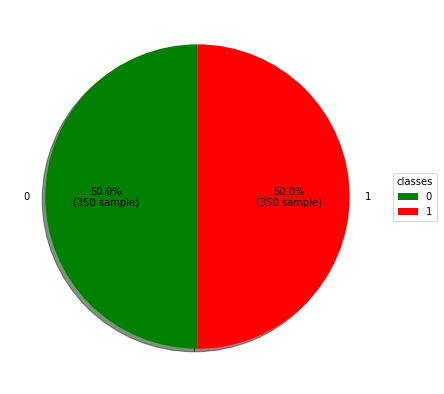

In [ ]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} sample)".format(pct, absolute)

# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(counts,
                                  autopct = lambda pct: func(pct, counts),
                                  labels = classes,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  textprops = dict(color ="black"))

# Adding legend
ax.legend(wedges, classes,
          title ="classes",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

Since the sample counts of the classes are equal, training set is balanced.

## Question 3.3

Train a Naive Bayes classifier using all of the data in the training set (
train-features.txt and train-labels.txt). Test your classifier on the test data (test-features.txt
and test-labels.txt, and report the testing accuracy as well as how many wrong predictions were made.
In estimating the model parameters use the above MLE estimator. IMPORTANT: if it arises in your code,
define 0 ∗ log 0 = 0 and a ∗ log 0, is as it is, that is -inf ). In case of ties, you should predict “non-spam”. In
the written part of your report what your test set accuracy is? What did your classifier end up predicting?
Why is using the MLE estimate is a bad idea in this situation?

---

### Training

In [ ]:
N_1 = len(train_dataset[train_dataset["y"] == 1])   # number of 1 labeled samples
N = len(train_dataset)                              # number of total samples
pi_y_1 = N_1 / N                                    # prior probability of given class 1 (spam)
vocab_size = 2500

# creating a list that contains sum of word counts for each row, to be able to use in calculations
word_cou_each_row = train_dataset.sum(axis=1)

# calculating the total number of words of the given class:
total_words_1 = sum([word_cou_each_row[i] for i in range(len(train_dataset)) \
               if train_dataset["y"][i] == 1])

total_words_0 = sum([word_cou_each_row[i] for i in range(len(train_dataset)) \
               if train_dataset["y"][i] == 0])

# calculating the number of occurrences of the words in given class:
T_j_0 = {i:sum(train_dataset[train_dataset["y"]==0][i]) for i in train_dataset.columns[:-1]}
T_j_1 = {i:sum(train_dataset[train_dataset["y"]==1][i]) for i in train_dataset.columns[:-1]}

# calculating the probabilities of the words in given class
Q_j_y_0 = {i:T_j_0[i]/total_words_0 for i in T_j_0.keys()}
Q_j_y_1 = {i:T_j_1[i]/total_words_1 for i in T_j_1.keys()}

### Test

In [ ]:
test_results = []

for x in tqdm(range(len(test_dataset))):

  test_sample = test_dataset.iloc[x][:-1]
  y_i = test_dataset["y"][x]

  prob_y_0 = np.log2(1 - pi_y_1) + sum([test_sample[i] * np.log2(Q_j_y_0[i]) \
                                        if Q_j_y_0[i]!= 0 else test_sample[i] for i in test_dataset.columns[:-1]])

  prob_y_1 = np.log2(pi_y_1) + sum([test_sample[i] * np.log2(Q_j_y_1[i]) \
                                    if Q_j_y_1[i]!= 0 else test_sample[i] for i in test_dataset.columns[:-1]])

  y_hat_i = np.argmax([prob_y_0, prob_y_1]) if prob_y_1 != prob_y_0 else 0

  test_results.append(y_hat_i)


100%|██████████| 260/260 [00:12<00:00, 20.62it/s]


### Test results

***Confusion matrix:***

In [ ]:
confusion_matrix(test_dataset["y"], test_results)

array([[ 42,  88],
       [ 24, 106]])

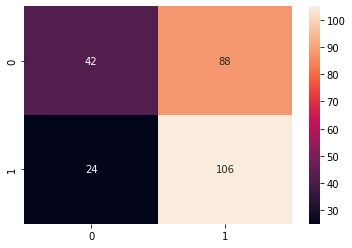

In [ ]:
sns.heatmap(confusion_matrix(test_dataset["y"], test_results), annot=True, robust=True, fmt='g')

***Classification report:***

In [ ]:
print(classification_report(test_dataset["y"], test_results))

              precision    recall  f1-score   support

           0       0.64      0.32      0.43       130
           1       0.55      0.82      0.65       130

    accuracy                           0.57       260
   macro avg       0.59      0.57      0.54       260
weighted avg       0.59      0.57      0.54       260



### Let's create a NaiveBayesClassifier class for easier implementation

In [ ]:
class NaiveBayesClassifier:
  def __init__(self, train_dataset):
    self.data = train_dataset

    # creating a list that contains sum of word counts for each row, to be able to use in calculations:
    self.word_cou_each_row = self.data.sum(axis=1)


  def train(self):
    N_1 = len(self.data[self.data["y"] == 1])   # number of 1 labeled samples
    N = len(self.data)                          # number of total samples
    self.pi_y_1 = N_1 / N                       # prior probability of given class 1 (spam)

    # since the last column is for labels (y), we can define vocab size as:
    vocab_size = len(self.data.columns[:-1])

    # calculating the total number of words for each given class:
    total_words_1 = sum([self.word_cou_each_row[i] for i in range(len(self.data)) \
                  if self.data["y"][i] == 1])

    total_words_0 = sum([self.word_cou_each_row[i] for i in range(len(self.data)) \
                  if self.data["y"][i] == 0])

    # calculating the number of occurrences of the words for each given class:
    T_j_0 = {i:sum(self.data[self.data["y"]==0][i]) for i in self.data.columns[:-1]}
    T_j_1 = {i:sum(self.data[self.data["y"]==1][i]) for i in self.data.columns[:-1]}

    # calculating the probabilities of the words in given class
    self.Q_j_y_0 = {i:T_j_0[i]/total_words_0 for i in T_j_0.keys()}
    self.Q_j_y_1 = {i:T_j_1[i]/total_words_1 for i in T_j_1.keys()}


  def test(self, test_dataset):
    self.test_results = []
    self.test_dataset = test_dataset

    for x in tqdm(range(len(test_dataset))):

      test_sample = test_dataset.iloc[x][:-1]   # word vector of the particular test sample
      y_i = test_dataset["y"][x]                # label of the particular test sample

      # calculating the probabilities for each class
      prob_y_0 = np.log2(1 - self.pi_y_1) + sum([test_sample[i] * np.log2(self.Q_j_y_0[i]) \
                                            if self.Q_j_y_0[i]!= 0 else test_sample[i] for i in test_dataset.columns[:-1]])

      prob_y_1 = np.log2(self.pi_y_1) + sum([test_sample[i] * np.log2(self.Q_j_y_1[i]) \
                                        if self.Q_j_y_1[i]!= 0 else test_sample[i] for i in test_dataset.columns[:-1]])

      # taking the argmax to find the predicted class for the particular test sample:
      y_hat_i = np.argmax([prob_y_0, prob_y_1]) if prob_y_1 != prob_y_0 else 0

      self.test_results.append(y_hat_i)

    return self.test_results


  def plot_results(self):
    sns.heatmap(confusion_matrix(self.test_dataset["y"], self.test_results), annot=True, robust=True, fmt='g')
    print(classification_report(self.test_dataset["y"], self.test_results))

#### Usage

In [ ]:
nb_classifier = NaiveBayesClassifier(train_dataset)
nb_classifier.train()

100%|██████████| 260/260 [00:12<00:00, 20.66it/s]


              precision    recall  f1-score   support

           0       0.64      0.32      0.43       130
           1       0.55      0.82      0.65       130

    accuracy                           0.57       260
   macro avg       0.59      0.57      0.54       260
weighted avg       0.59      0.57      0.54       260



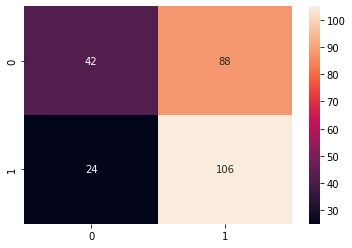

In [ ]:
nb_classifier.test(test_dataset)
nb_classifier.plot_results()

## Question 3.4

Extend your classifier so that it can compute an MAP estimate of
θ parameters using a fair Dirichlet prior. This corresponds to additive smoothing. The prior is fair in the sense that it “hallucinates” that each word appears additionally α times in the train set.

---

While solving this question, I will proceed through the class structure I created. First I will add an alpha parameter to the init function. Thus, we will be able to define the alpha value as optional while creating our model. Later on, I will include this alpha variable when calculating probabilities in the training phase of the model as applied in the formula.

In [ ]:
class NaiveBayesClassifier:
  def __init__(self, train_dataset, alpha=1):
    self.data = train_dataset

    # creating a list that contains sum of word counts for each row, to be able to use in calculations:
    self.word_cou_each_row = self.data.sum(axis=1)
    self.alpha = alpha


  def train(self):
    N_1 = len(self.data[self.data["y"] == 1])   # number of 1 labeled samples
    N = len(self.data)                          # number of total samples
    self.pi_y_1 = N_1 / N                       # prior probability of given class 1 (spam)

    # since the last column is for labels (y), we can define vocab size as:
    vocab_size = len(self.data.columns[:-1])

    # calculating the total number of words for each given class:
    total_words_1 = sum([self.word_cou_each_row[i] for i in range(len(self.data)) \
                  if self.data["y"][i] == 1])

    total_words_0 = sum([self.word_cou_each_row[i] for i in range(len(self.data)) \
                  if self.data["y"][i] == 0])

    # calculating the number of occurrences of the words for each given class:
    T_j_0 = {i:sum(self.data[self.data["y"]==0][i]) for i in self.data.columns[:-1]}
    T_j_1 = {i:sum(self.data[self.data["y"]==1][i]) for i in self.data.columns[:-1]}

    # calculating the probabilities of the words in given class
    self.Q_j_y_0 = {i:(T_j_0[i] + self.alpha)/(self.alpha * vocab_size + total_words_0) for i in T_j_0.keys()}
    self.Q_j_y_1 = {i:(T_j_1[i] + self.alpha)/(self.alpha * vocab_size + total_words_1) for i in T_j_1.keys()}


  def test(self, test_dataset):
    self.test_results = []
    self.test_dataset = test_dataset

    for x in tqdm(range(len(test_dataset))):

      test_sample = test_dataset.iloc[x][:-1]   # word vector of the particular test sample
      y_i = test_dataset["y"][x]                # label of the particular test sample

      # calculating the probabilities for each class
      prob_y_0 = np.log2(1 - self.pi_y_1) + sum([test_sample[i] * np.log2(self.Q_j_y_0[i]) \
                                            if self.Q_j_y_0[i]!= 0 else test_sample[i] for i in test_dataset.columns[:-1]])

      prob_y_1 = np.log2(self.pi_y_1) + sum([test_sample[i] * np.log2(self.Q_j_y_1[i]) \
                                        if self.Q_j_y_1[i]!= 0 else test_sample[i] for i in test_dataset.columns[:-1]])

      # taking the argmax to find the predicted class for the particular test sample:
      y_hat_i = np.argmax([prob_y_0, prob_y_1]) if prob_y_1 != prob_y_0 else 0

      self.test_results.append(y_hat_i)

    return self.test_results


  def plot_results(self):
    sns.heatmap(confusion_matrix(self.test_dataset["y"], self.test_results), annot=True, robust=True, fmt='g')
    print(classification_report(self.test_dataset["y"], self.test_results))

In [ ]:
nb_classifier = NaiveBayesClassifier(train_dataset)
nb_classifier.train()

100%|██████████| 260/260 [00:13<00:00, 19.28it/s]


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       130
           1       0.98      0.97      0.97       130

    accuracy                           0.97       260
   macro avg       0.97      0.97      0.97       260
weighted avg       0.97      0.97      0.97       260



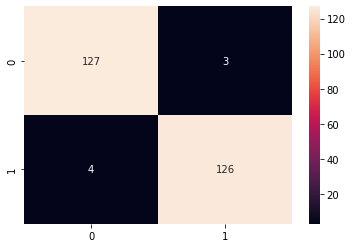

In [ ]:
nb_classifier.test(test_dataset)
nb_classifier.plot_results()